In [32]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss

In [33]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data"
dataframe = pandas.read_csv(url, header=-1)

KeyError: False

In [9]:
#ONE-HOT ENCODING
dumm = pandas.get_dummies(dataframe, prefix=None, prefix_sep='_', dummy_na=False, columns=[0,8], sparse=False, drop_first=False)

y = dumm.as_matrix(columns=dumm.columns[-28:])
X = dumm.as_matrix(columns=dumm.columns[:-28])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [10]:
#ONE-HOT ENCODING
dumm = pandas.get_dummies(dataframe, 
                          prefix=None, 
                          prefix_sep='_', 
                          dummy_na=False, 
                          columns=[0,8], 
                          sparse=False, 
                          drop_first=False)

y = dumm.as_matrix(columns=dumm.columns[-28:])
X = dumm.as_matrix(columns=dumm.columns[:-28])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)    

In [11]:
# FUNCTIONS FOR FORWARD PASS
def ReLU(x):
    return x*(x > 0)


def softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)


# FUNCTIONS FOR BACKPROP
def differentiate_ReLU(x):
    x[x <= 0] = 0
    x[x > 0] = 1
    return x

def differentiate_tanh(a_1):
    return 1 - np.tanh(a_1)**2

In [26]:
class NeuralNetwork:
    def __init__(self, neurons_first, neurons_second, x, y):
        np.random.seed(4)
        
        self.W_1 = np.random.rand(neurons_first,x.shape[1]).astype(np.float32) * np.sqrt(2.0/(neurons_first))
        self.W_2 = np.random.rand(neurons_second,neurons_first).astype(np.float32) * np.sqrt(2.0/(neurons_second))
        self.W_out = np.random.rand(y.shape[1],neurons_second).astype(np.float32) * np.sqrt(2.0/(y.shape[1]))
        self.W_ResNet = np.random.rand(y.shape[1],x.shape[1]) * np.sqrt(2.0/(y.shape[1]))
        
        self.b_1 = np.zeros((neurons_first,1)).astype(np.float32)
        self.b_2 = np.zeros((neurons_second,1)).astype(np.float32)
        self.b_out = np.zeros((y.shape[1],1)).astype(np.float32)
        
            

def feedforward(network, x, y):
        forward_path = dict()
        
        forward_path['x'] = x.T
        forward_path['y'] = y.T
        
        forward_path['a_1'] = np.add(network.W_1.dot(forward_path['x']), network.b_1)
        forward_path['z_1'] = np.tanh(forward_path['a_1'])
        forward_path['a_2'] = np.add(network.W_2.dot(forward_path['z_1']), network.b_2)
        forward_path['z_2'] = ReLU(forward_path['a_2'])
        forward_path['a_out_1'] = network.W_out.dot(forward_path['z_2'])
        forward_path['a_out_2'] = network.W_ResNet.dot(forward_path['x'])
        forward_path['a_out'] = np.add(np.add(forward_path['a_out_1'], forward_path['a_out_2']), network.b_out)
        forward_path['z_out'] = softmax(forward_path['a_out'])
        
        return forward_path
        
        
def backward_path(network, forward_path, learning_rate):
        gradient = dict()
        
        derivative_of_tanh = differentiate_tanh(forward_path['a_1'])
        derivative_of_ReLU = differentiate_ReLU(forward_path['a_2'])
 
        # application of the chain rule to find derivative of the loss function with respect to weights2 and weights1
        delta_out = forward_path['y'] - forward_path['z_out'] 
        
        first_mul = network.W_out.T.dot(delta_out)
        delta_2 = np.multiply(derivative_of_ReLU, first_mul)
        delta_1 = np.multiply(derivative_of_tanh, network.W_2.T.dot(delta_2))
            
        dW_ResNet = delta_out.dot(forward_path['x'].T)
        dW_out = delta_out.dot(forward_path['z_2'].T)
        dW_2 = delta_2.dot(forward_path['z_1'].T)
        dW_1 = delta_1.dot(forward_path['x'].T)
        
        network.W_1 += learning_rate *  dW_1
        network.W_2 += learning_rate * dW_2
        network.W_out += learning_rate * dW_out
        network.W_ResNet += learning_rate * dW_ResNet
        
        network.b_1 += learning_rate * np.expand_dims(np.mean(delta_1, axis=1), axis=1)
        network.b_2 += learning_rate * np.expand_dims(np.mean(delta_2, axis=1), axis=1)
        network.b_out += learning_rate * np.expand_dims(np.mean(delta_out, axis=1), axis=1)

        
def train(epochs, batch_size, learning_rate, nn):
#     X_train, X_test, y_train, y_test
    
    evaluation = dict()
    evaluation['batch_size'] = "batch size: {}".format(batch_size)
    evaluation['learning_rate'] = "learning rate: {}".format(learning_rate)
    evaluation['epoch'] = []
    evaluation['log_loss'] = []
    evaluation['accuracy'] = []
    
    for epoch in range(epochs):
        evaluation['epoch'].append(epoch)
        current = 0
        for i in range(len(X_train)//batch_size):
            forward_path = feedforward(nn, X_train[current:current+batch_size], y_train[current:current+batch_size])
            backward_path(nn, forward_path, learning_rate)
            current += batch_size
            
        if(len(X_train)%batch_size != 0):
            k = len(X_train)%batch_size
     
            forward_path = feedforward(nn, X_train[-k:], y_train[-k:])
            backward_path(nn, forward_path, learning_rate)
           
        forward_path = feedforward(nn, X_test, y_test)
        evaluation['log_loss'].append(log_loss(y_test, forward_path['z_out'].T))
        evaluation['accuracy'].append(getAccuracy(forward_path['z_out'].T,y_test))
      
    return evaluation


def get_accuracy (output,y):
    prede = np.argmax(output,axis=0)
    real = np.argmax(y,axis=0)
    accuracy = sum(prede == real)/(float(len(y)))
    return accuracy


def evaluate_model(epocs):
    nn = NeuralNetwork(19, 19, X_train, y_train)
    batches = [20,30,40,60]
    learning_rates = [0.0001,0.001,0.005,0.002]
    
    results = dict()
    
    results['batches'] = []
    results['rates'] = []
    
    for batch in batches:
        results['batches'].append(train(epochs, batch, 0.01, nn))
        
    for rate in learning_rates:
        results['rates'].append(train(epochs, 40, rate, nn))
        
    return results

In [27]:
results = evaluate_model(10)

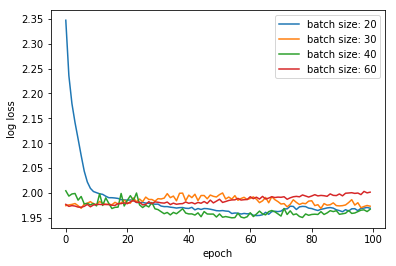

In [28]:
experiments_with_batch = results['batches']
        
fig = plt.figure()
ax = plt.axes()

for experiment in experiments_with_batch:
     ax.plot(experiment['epoch'], experiment['log_loss'], label=experiment['batch_size']);

plt.ylabel('log loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

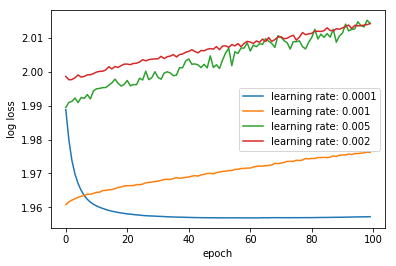

In [29]:
experiments_with_rates = results['rates']
        
fig = plt.figure()
ax = plt.axes()

for experiment in experiments_with_rates:
    ax.plot(experiment['epoch'], experiment['log_loss'], label=experiment['learning_rate']);

plt.ylabel('log loss')
plt.xlabel('epoch')
plt.legend()
plt.show()

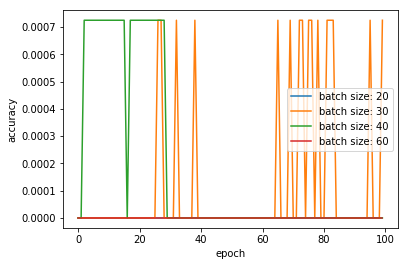

In [30]:
experiments_with_batch = results['batches']
        
fig = plt.figure()
ax = plt.axes()

for experiment in experiments_with_batch:
     ax.plot(experiment['epoch'], experiment['accuracy'], label=experiment['batch_size']);

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()


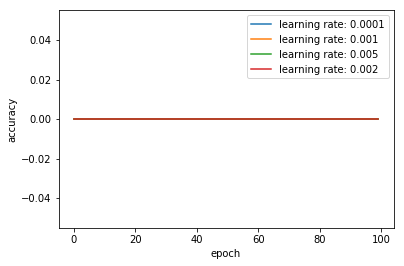

In [31]:
experiments_with_batch = results['rates']
        
fig = plt.figure()
ax = plt.axes()

for experiment in experiments_with_batch:
     ax.plot(experiment['epoch'], experiment['accuracy'], label=experiment['learning_rate']);

plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend()
plt.show()